# Python ambient occlusion renderer

In [1]:
import mitsuba as mi
import drjit as dr

In [2]:
mi.set_variant('llvm_ad_rgb')

In [32]:
scene = mi.load_file('../scenes/cbox.xml')

2022-03-09 17:45:25 INFO main [xml.cpp:1260] Loading XML file "../scenes/cbox.xml" with variant "llvm_ad_rgb"..

2022-03-09 17:45:25 INFO main [Scene] Embree ready. (took 2ms)

2022-03-09 17:45:25 INFO main [xml.cpp:1319] Done loading XML file "../scenes/cbox.xml" (took 20ms).

In [42]:
cam_o = [0, 0, 4]
cam_width = 1.0
cam_height = cam_width

image_res = 256

x, y = dr.meshgrid(
    dr.linspace(mi.Float, -cam_width,  cam_width,  image_res),
    dr.linspace(mi.Float, cam_height, -cam_height, image_res),
)

rays = mi.Ray3f(
    o=mi.Point3f(x, y, 0) + cam_o, 
    d=mi.Vector3f(0, 0, -1)
)

In [43]:
si = scene.ray_intersect(rays)

rng = mi.PCG32(size=image_res**2)
i, result = mi.UInt32(0), mi.Float(0)
loop = mi.Loop(name="", state=lambda: (rng, i, result))
while loop(si.is_valid() & (i < 256)):
    sin_phi, cos_phi = dr.sincos(rng.next_float32() * dr.TwoPi)
    sin_theta_2 = rng.next_float32()
    wo_local = mi.Vector3f(
        cos_phi * dr.sqrt(sin_theta_2),
        sin_phi * dr.sqrt(sin_theta_2),
        dr.sqrt(1.0 - sin_theta_2)
    )

    ray_2 = si.spawn_ray(si.sh_frame.to_world(wo_local))
    ray_2.maxt = 1.5

    result[~scene.ray_test(ray_2)] += 1.0
    i += 1

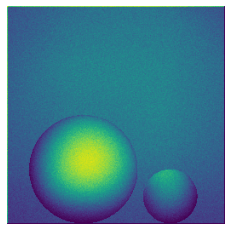

In [44]:
image = mi.TensorXf(result, shape=(image_res, image_res))

import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(image * 2);